In [249]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geodatasets import get_path
from sklearn.cluster import KMeans

In [3]:
states = gpd.read_file("ne_10m_admin_1_states_provinces.shp")
australian_states = states[states['admin'] == 'Australia']

# 1. Read excel file

The hand over material contains:
- Product master
- Packaging master
- Facility master
- Collection point capacity
- Customer master
- Sale order

In [4]:
filename='SCMission 2023_Round 3_raw_Data.xlsx'
Customer_Master = pd.read_excel(filename, sheet_name='Customer_Master')
Customer_Master=Customer_Master[:-1]
Data_Master = pd.read_excel(filename, sheet_name="Data_Master")

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [302]:
Product_Master= Data_Master.iloc[0:37, 0:17]
Product_Master= Product_Master.rename(columns=Product_Master.iloc[0])
Product_Master = Product_Master[1:]

In [7]:
Packaging_Master = Data_Master.iloc[39:50, 0:5]
Packaging_Master = Packaging_Master.rename(columns=Packaging_Master.iloc[0])
Packaging_Master = Packaging_Master.ffill()
Packaging_Master= Packaging_Master[1:]

In [8]:
Facility_Master = Data_Master.iloc[52:73, 0:11]
Facility_Master = Facility_Master.rename(columns=Facility_Master.iloc[0])
Facility_Master = Facility_Master[1:]

In [303]:
Collection_Point_Capacity = Data_Master.iloc[82:86, 0:6]
Collection_Point_Capacity = Collection_Point_Capacity.rename(columns=Collection_Point_Capacity.iloc[0])
Collection_Point_Capacity = Collection_Point_Capacity[1:]
Collection_Point_Capacity = Collection_Point_Capacity.ffill()

In [309]:
Sales_Order = pd.read_excel(filename, sheet_name= 'Sales_Order')
# Filter rows in year 2022
Sales_Order_2022 = Sales_Order.loc[(Sales_Order['SOCreationDate'].dt.year == 2022)]
Sales_Order_2022.dropna(axis=0, inplace=True)
Sales_Order_2022 = Sales_Order_2022.dropna(axis = 0).copy()

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\Admin\AppData\Local\Temp\ipykernel_1304\4087244006.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sales_Order_2022.dropna(axis=0, inplace=True)


In [304]:
Product_Master['ProductID'] = Product_Master['ProductID'].astype('int64')
Package_Per_Sales_Order = pd.merge(Sales_Order_2022[['GoodsIssueDate','ProductID', "CustomerRef", 'GrossWeightInKg','NetWeightInKg']],
                                   Product_Master[['ProductID', 'KgPerPallet', 'Unit']],on='ProductID',how='inner')
Package_Per_Sales_Order['Pallets']=(Package_Per_Sales_Order['NetWeightInKg']/Package_Per_Sales_Order['KgPerPallet']).astype(float).round(2)

In [305]:
Package_Per_Sales_Order['GoodsIssueDate'] = pd.to_datetime(Package_Per_Sales_Order['GoodsIssueDate'])
# Set the 'GoodsIssueDate' column as the index
Package_Per_Sales_Order.set_index('GoodsIssueDate', inplace=True)
# Group the data by week and customer, and calculate the sum of pallets
weekly_pallets = Package_Per_Sales_Order.groupby([pd.Grouper(freq='W'), 'CustomerRef'])['Pallets'].sum()
# Reset the index to make it a DataFrame
weekly_pallets = weekly_pallets.reset_index()

# 2. Clustering Customers

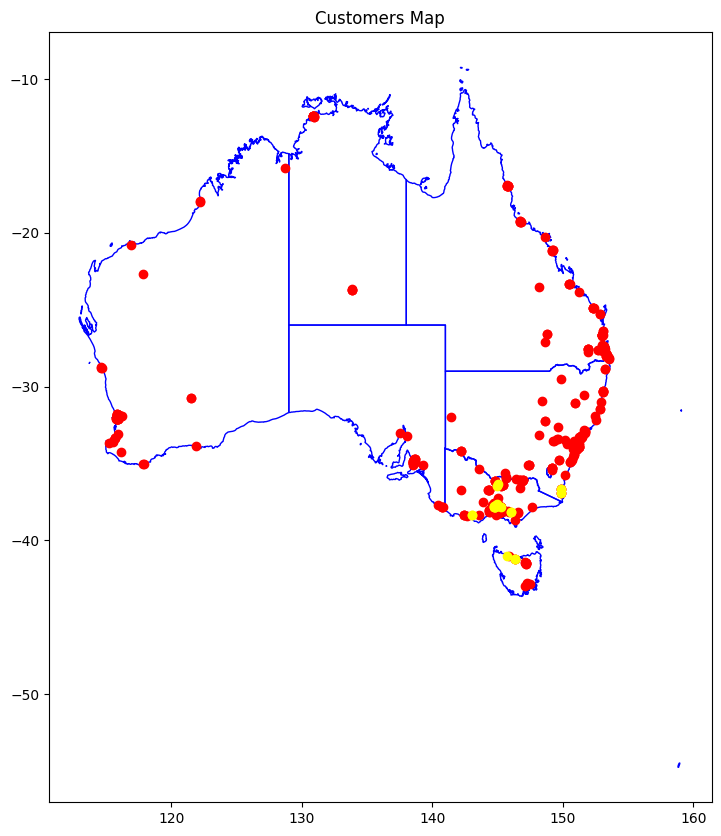

In [311]:
gdf = gpd.GeoDataFrame(
    Customer_Master, geometry=gpd.points_from_xy(Customer_Master.Longitude, Customer_Master.Latitude), crs="EPSG:4326")
# Tạo subplot
fig, ax = plt.subplots(figsize=(10, 10))
# Hiển thị dia giới các bang
australian_states.plot(ax=ax, color='none', edgecolor='blue', linewidth=1)
ax.scatter(Customer_Master['Longitude'], Customer_Master['Latitude'], color = 'red')
ax.scatter(Facility_Master['Longitude'], Facility_Master['Latitude'], color='yellow')
# Đặt tên cho subplot
ax.set_title('Customers Map')
# Hiển thị bản đồ
plt.show()

Customers appear significantly in the East Australia.  CreamWorks facilities is also in there. 

So we decided to distribute the West Australia into a cluster and the rest is clustered by Kmeans method.

Three attributes we used to cluster are Longitude, Latitude and Sale organization 

In [14]:
West_Cluster = pd.DataFrame()
Cluster_South_Australia= Customer_Master[Customer_Master['State']=="South Australia"]
West_Cluster = pd.concat([West_Cluster, Cluster_South_Australia], axis=0)
Rest_Customer = Customer_Master.drop(Customer_Master[Customer_Master["State"]=="South Australia"].index, axis=0)

Cluster_Northern_Territory= Customer_Master[Customer_Master['State']=="Northern Territory"]
West_Cluster = pd.concat([West_Cluster, Cluster_Northern_Territory], axis=0)
Rest_Customer = Rest_Customer.drop(Rest_Customer[Rest_Customer["State"]=="Northern Territory"].index, axis=0)

Cluster_Western_Australia = Customer_Master[Customer_Master['State']=="Western Australia"]
West_Cluster = pd.concat([West_Cluster, Cluster_Western_Australia], axis=0)
Rest_Customer = Rest_Customer.drop(Rest_Customer[Rest_Customer["State"]=="Western Australia"].index, axis=0)

West_Cluster['Cluster'] = pd.Series(5, index=West_Cluster.index)

West_Cluster.value_counts("Cluster")

Cluster
5    123
Name: count, dtype: int64

In Tastamia island, there are few customers. But the transportation is difficulty because of the sea. 

So we distributed it to a cluster

In [317]:
Cluster_Tasmania = Customer_Master[Customer_Master['State']=="Tasmania"]
Cluster_Tasmania['Cluster'] = pd.Series(6, index=Cluster_Tasmania.index)
Rest_Customer = Rest_Customer.drop(Rest_Customer[Rest_Customer["State"]=="Tasmania"].index, axis=0)
Cluster_Tasmania.value_counts("Cluster")

C:\Users\Admin\AppData\Local\Temp\ipykernel_1304\1898329386.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cluster_Tasmania['Cluster'] = pd.Series(6, index=Cluster_Tasmania.index)


Cluster
6    19
Name: count, dtype: int64

In [16]:
Cluster_Western_Australia = Customer_Master[Customer_Master['State']=="Western Australia"]
Rest_Customer = Rest_Customer.drop(Rest_Customer[Rest_Customer["State"]=="Western Australia"].index, axis=0)
Cluster_Western_Australia.value_counts('Channel')
Rest_Customer.value_counts("State").sum()

555

In [318]:
Rest_Customer['Organization'] = np.where(Rest_Customer['SalesOrganization'] == 'Organization 1', 0,
                                             np.where(Rest_Customer['SalesOrganization'] == 'Organization 2', 25, 10))

In [319]:
locations = np.array([Rest_Customer['Longitude'], Rest_Customer['Latitude'], Rest_Customer["Organization"]]).T
kmeans = KMeans(n_clusters=5, random_state=4, n_init=20)
kmeans.fit(locations)
cluster_labels = kmeans.predict(locations)
unique_values, counts = np.unique(cluster_labels, return_counts=True)
# Print the results
print(unique_values)
print(counts)

[0 1 2 3 4]
[103  91  99 189  73]


In [74]:
Rest_Customer['Cluster'] = pd.Series(kmeans.labels_, index=Rest_Customer.index)
Rest_Customer.value_counts("Cluster")

Cluster
3    189
0    103
2     99
1     91
4     73
Name: count, dtype: int64

In [112]:
Customer_Master = pd.DataFrame()
Customer_Master = pd.concat([West_Cluster, pd.concat([Cluster_Tasmania, Rest_Customer])])

Customer_Master["Cluster"][141]=7


C:\Users\Admin\AppData\Local\Temp\ipykernel_1304\1104236366.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Customer_Master["Cluster"][141]=7


In [113]:
Customer_Master.value_counts('Cluster')


Cluster
3    189
5    123
0    103
2     98
1     91
4     73
6     19
7      1
Name: count, dtype: int64

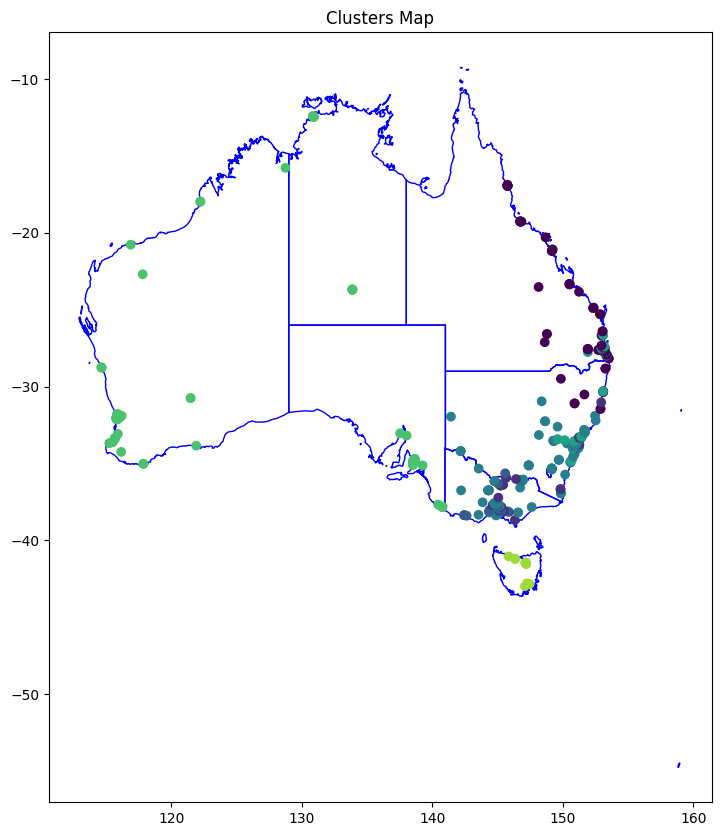

In [314]:

gdf = gpd.GeoDataFrame(
    Customer_Master, geometry=gpd.points_from_xy(Customer_Master.Longitude, Customer_Master.Latitude), crs="EPSG:4326")
# Tạo subplot
fig, ax = plt.subplots(figsize=(10, 10))


# Hiển thị dia giới các bang
australian_states.plot(ax=ax, color='none', edgecolor='blue', linewidth=1)

ax.scatter(Customer_Master['Longitude'], Customer_Master['Latitude'], c=Customer_Master['Cluster'])

# Đặt tên cho subplot
ax.set_title('Clusters Map')

# Hiển thị bản đồ
plt.show()

# 3. Calculating requirements

## 3.1. Quantity and capacity of collection points



In [104]:
Customer_Master[Customer_Master["Cluster"]==1].value_counts("Organization")
#Found that all customer in cluster 1 do not have any order in 2022. So we decided to delete this cluster

Organization
25.0    91
Name: count, dtype: int64

In [315]:
Product_Master['ProductID'] = Product_Master['ProductID'].astype('int64')
Package_Per_Sales_Order = pd.merge(Sales_Order_2022[['GoodsIssueDate','ProductID', "CustomerRef", 'GrossWeightInKg','NetWeightInKg']],
                                   Product_Master[['ProductID', 'KgPerPallet', 'Unit']],on='ProductID',how='inner')
Package_Per_Sales_Order['Pallets']=(Package_Per_Sales_Order['NetWeightInKg']/Package_Per_Sales_Order['KgPerPallet']).astype(float).round(2)
Cluster_Pallets_Weekly = pd.merge(Package_Per_Sales_Order, Customer_Master[['CustomerRef',"Cluster"]], on='CustomerRef',how='inner')

Cluster_Pallets_Weekly['GoodsIssueDate'] = pd.to_datetime(Cluster_Pallets_Weekly['GoodsIssueDate'])

# Set the 'GoodsIssueDate' column as the index
Cluster_Pallets_Weekly.set_index('GoodsIssueDate', inplace=True)

# Group the data by week and customer, and calculate the sum of pallets
weekly_pallets = Cluster_Pallets_Weekly.groupby([pd.Grouper(freq='W'), 'Cluster'])['Pallets'].sum()

# Reset the index to make it a DataFrame
weekly_pallets = weekly_pallets.reset_index()


In [336]:
OverFlow_Pallets = []
CollectionPoints = pd.DataFrame(columns=['Small', 'Medium', 'Big'], index= range(0,8))

In [198]:
for i in range(8):
    print(weekly_pallets[weekly_pallets["Cluster"]==i].max())

GoodsIssueDate    2023-01-15 00:00:00
Cluster                             0
Pallets                        118.18
dtype: object
GoodsIssueDate    NaT
Cluster           NaN
Pallets           NaN
dtype: object
GoodsIssueDate    2023-01-15 00:00:00
Cluster                             2
Pallets                         49.48
dtype: object
GoodsIssueDate    2023-01-15 00:00:00
Cluster                             3
Pallets                        804.76
dtype: object
GoodsIssueDate    2023-01-08 00:00:00
Cluster                             4
Pallets                          23.3
dtype: object
GoodsIssueDate    2023-01-15 00:00:00
Cluster                             5
Pallets                        145.45
dtype: object
GoodsIssueDate    2023-01-08 00:00:00
Cluster                             6
Pallets                          8.02
dtype: object
GoodsIssueDate    2023-01-08 00:00:00
Cluster                             7
Pallets                       2396.55
dtype: object


Two small collection points for this cluster


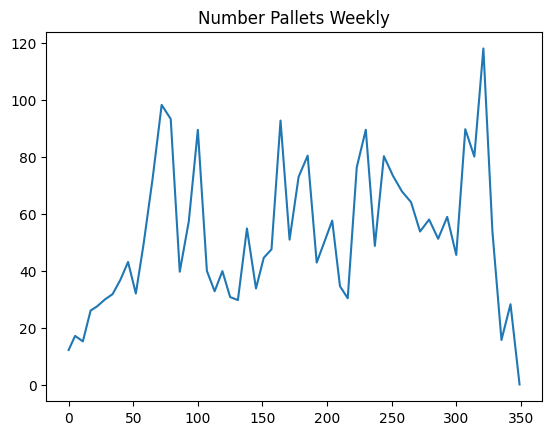

In [221]:
Cluster0 = weekly_pallets[weekly_pallets['Cluster']==0]
Cluster0["Pallets"].plot(title = 'Number Pallets Weekly')
print(f"Two small collection points for this cluster")
OverFlow_Pallets.append(sum(Cluster0[Cluster0['Pallets']>140]["Pallets"]-140))
CollectionPoints['Small'][0]=2
CollectionPoints['Medium'][0]=0
CollectionPoints['Big'][0]=0

In [335]:
Cluster1 = weekly_pallets[weekly_pallets['Cluster']==1]
#Cluster1["Pallets"].plot(title = 'Number Pallets Weekly')

print(f"Total pallets in this cluster: {sum(Cluster1['Pallets'])}")
print("As we see, this cluster have no order in 2022, so we ignore this cluster")
CollectionPoints['Small'][1]=0
CollectionPoints['Medium'][1]=0
CollectionPoints['Big'][1]=0

Total pallets in this cluster: 0
As we see, this cluster have no order in 2022, so we ignore this cluster


In [331]:
Cluster2 = weekly_pallets[weekly_pallets['Cluster']==2]
print("One small collection points for this cluster")
OverFlow_Pallets.append(sum(Cluster2[Cluster2['Pallets']>70]["Pallets"]-70))
CollectionPoints['Small'][2]=1
CollectionPoints['Medium'][2]=0
CollectionPoints['Big'][2]=0
#Cluster2["Pallets"].plot(title = 'Number Pallets Weekly')

One small collection points for this cluster


In [330]:
Cluster3 = weekly_pallets[weekly_pallets['Cluster']==3]
Cluster3_OverFlow = Cluster3[Cluster3['Pallets']>1100]
print("A big collection point for this cluster")
OverFlow_Pallets.append(sum(Cluster3[Cluster3['Pallets']>1100]["Pallets"]-1100))
CollectionPoints['Small'][3]=0
CollectionPoints['Medium'][3]=0
CollectionPoints['Big'][3]=1
#Cluster3["Pallets"].plot(title = 'Number Pallets Weekly')

A big collection point for this cluster


One collection point for this cluster


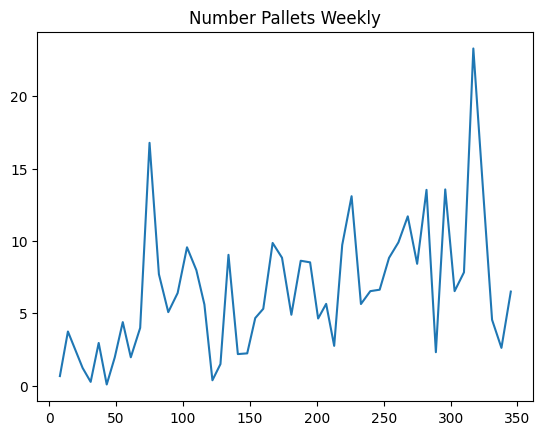

In [225]:
Cluster4 = weekly_pallets[weekly_pallets['Cluster']==4]
Cluster4_OverFlow = Cluster4[Cluster4['Pallets']>70]
Cluster4["Pallets"].plot(title = 'Number Pallets Weekly')
print("One collection point for this cluster")
OverFlow_Pallets.append(sum(Cluster4[Cluster4['Pallets']>70]["Pallets"]-70))
CollectionPoints['Small'][4]=1
CollectionPoints['Medium'][4]=0
CollectionPoints['Big'][4]=0

Two small collection points for this cluster


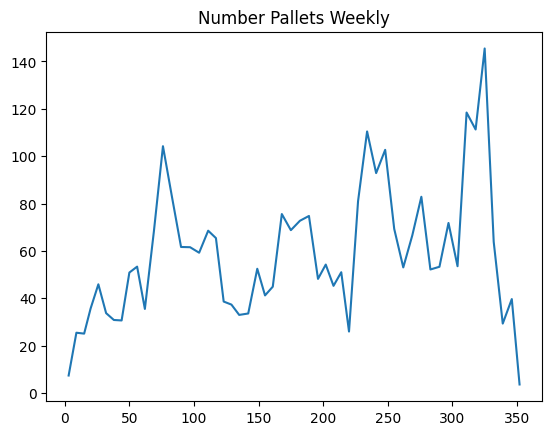

In [226]:
Cluster5 = weekly_pallets[weekly_pallets['Cluster']==5]
Cluster5_OverFlow = Cluster5[Cluster5['Pallets']>140]
Cluster5["Pallets"].plot(title = 'Number Pallets Weekly')
print("Two small collection points for this cluster")
OverFlow_Pallets.append(sum(Cluster5[Cluster5['Pallets']>140]["Pallets"]-140))
CollectionPoints['Small'][5]=2
CollectionPoints['Medium'][5]=0
CollectionPoints['Big'][5]=0

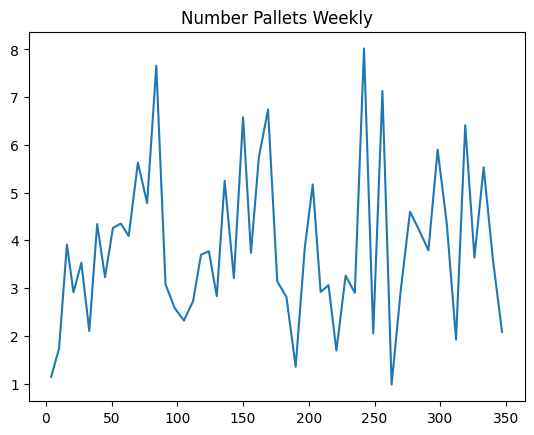

In [227]:
Cluster6 = weekly_pallets[weekly_pallets['Cluster']==6]
Cluster6_OverFlow = Cluster6[Cluster6['Pallets']>70]
Cluster6["Pallets"].plot(title = 'Number Pallets Weekly')
sum(Cluster6_OverFlow["Pallets"]-70)
#This cluster in Tastamia, so we decided to merge this collection point into Plants
CollectionPoints['Small'][6]=0
CollectionPoints['Medium'][6]=0
CollectionPoints['Big'][6]=0

In [328]:
Cluster7 = weekly_pallets[weekly_pallets['Cluster']==7]
Cluster7_OverFlow = Cluster7[Cluster7['Pallets']>(1100*2+70)]
OverFlow_Pallets.append(sum(Cluster7[Cluster7['Pallets']>2270]["Pallets"]-2270))
CollectionPoints['Small'][7]=0
CollectionPoints['Medium'][7]=0
CollectionPoints['Big'][7]=2
#Cluster7["Pallets"].plot(title = 'Number Pallets Weekly')

We have significant customer in cluster 7, so we need to focus on them. 
We decided to build 2 big collection points close to this customer.  
This is our effort to maintain and develope relationship with them

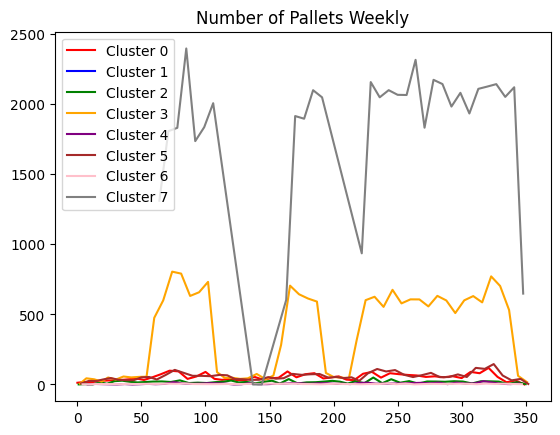

In [247]:
fig, ax = plt.subplots()

# Plot each line with color and label
Cluster0["Pallets"].plot(color='red', label='Cluster 0', title='Number of Pallets Weekly')
Cluster1["Pallets"].plot(color='blue', label='Cluster 1', title='Number of Pallets Weekly')
Cluster2["Pallets"].plot(color='green', label='Cluster 2', title='Number of Pallets Weekly')
Cluster3["Pallets"].plot(color='orange', label='Cluster 3', title='Number of Pallets Weekly')
Cluster4["Pallets"].plot(color='purple', label='Cluster 4', title='Number of Pallets Weekly')
Cluster5["Pallets"].plot(color='brown', label='Cluster 5', title='Number of Pallets Weekly')
Cluster6["Pallets"].plot(color='pink', label='Cluster 6', title='Number of Pallets Weekly')
Cluster7["Pallets"].plot(ax=ax, color='gray', label='Cluster 7', title='Number of Pallets Weekly')
# Add legend
ax.legend()
# Show the plot
plt.show()


## 3.2. Related cost
- Collection points cost

In the give material, the company will transport the return packages when distributing goods to the customers.

So we won't calculate transportation cost. Locating collection points close to CreamWorks facilities is the most cost effective

In [248]:
OverFlow = sum(OverFlow_Pallets)
print(f"Over flow pallets: {OverFlow}")
Total_Pallets = sum(weekly_pallets['Pallets'])
print(f"Total pallets: {Total_Pallets}")
print(f"The percentage of overflow: {OverFlow/Total_Pallets*100}")
Total_Annual_Cost= sum([sum(CollectionPoints['Small'])*7,sum(CollectionPoints["Medium"])*23,sum(CollectionPoints['Big'])*110])*1000
print(f"Total annual pallets cost: {Total_Annual_Cost}")
OverFlow_Cost = OverFlow*3
print(f"Over flow cost: {OverFlow_Cost}")
Total_Cost = Total_Annual_Cost+OverFlow_Cost
print(f"Total collection points cost: {Total_Cost}")
CollectionPoints

Over flow pallets: 928.4200000000003
Total pallets: 85284.67999999998
The percentage of overflow: 1.088612866929911
Total annual pallets cost: 372000
Over flow cost: 2785.260000000001
Total collection points cost: 374785.26


,Small,Medium,Big
0,2,0,0
1,0,0,0
2,1,0,0
3,0,0,1
4,1,0,0
5,2,0,0
6,0,0,0
7,0,0,2


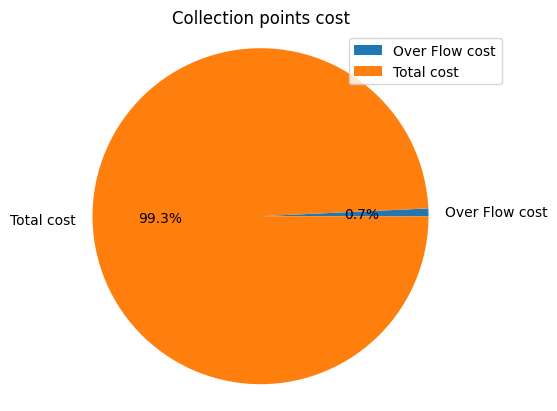

In [327]:
sizes = [OverFlow_Cost, Total_Cost]
labels = ['Over Flow cost', 'Total cost']
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Collection points cost')
plt.axis('equal')
plt.legend()
plt.show()

## 3.3. The percentage of Inflow 


In [337]:
Package_Per_Sales_Order['Packaging']=(Package_Per_Sales_Order['GrossWeightInKg']-Package_Per_Sales_Order['NetWeightInKg']).astype(float)
Units = ['CTN','PBOT','GBOT']
weight = []
for unit in Units:
    weight.append(sum(Package_Per_Sales_Order[Package_Per_Sales_Order['Unit']==unit]['Packaging']))

In [338]:
print(Units)
weight

['CTN', 'PBOT', 'GBOT']


[513950.40239998896, 226962.80999999947, 1891350.5724000027]

In [339]:
Non_virginInflow=0.7*sum(weight[0:2])+0.95*weight[-1]
RenewableInflow = sum(weight)-Non_virginInflow
Inflow = (Non_virginInflow+RenewableInflow)/(sum(weight)+RenewableInflow)
print(f"With 55% recycled content of CTN and PBOT, and 95% recycled GBOT\nWe propose {Inflow} percentage of inflow")

With 55% recycled content of CTN and PBOT, and 95% recycled GBOT
We propose 0.8925635192490428 percentage of inflow


## 3.4.  The reduced percentage of GHG emissions

In [340]:
GHG_before = []
GHG_after = []
GHG_CollectionPoints = Total_Pallets*0.5*2.4*0.371

GHG_before.append(0.05*weight[0]*0.57+0.95*weight[0]*0.7)
GHG_after.append(0.55*weight[0]*0.57+ 0.45*weight[0]*0.7)
GHG_before.append(0.1*weight[1]*1.7 + 0.9*weight[1]*3.1)
GHG_after.append(0.55*weight[1]*1.7+ 0.45*weight[1]*3.1)
GHG_before.append(1.2*weight[2])
GHG_after.append(0.95*weight[2]*0.55+0.05*weight[2]*1.2)

In [348]:
print(sum(GHG_before))
print(sum(GHG_after))
GHG_reduced = 100-100*(sum(GHG_after)/(sum(GHG_before)+GHG_CollectionPoints))
print(f'The reduced percentage of GHG emissions: {round(GHG_reduced,3)}%')

3297855.208544394
1953552.8836313935
The reduced percentage of GHG emissions: 41.437%
